In [1]:
from tcsim.system import*
from tcsim.visualization import*
from tcsim.gates import*
import numpy as np
from scipy import optimize
from qutip import*


Q = (a + a.dag())/2
P = 1j*(a-a.dag())/2

def char_func_cut(state, xvec, axis = 1):
    """Calculate the Characteristic function as a 2Dgrid (xvec, xvec) for a given state.

    Args:
        state (Qobject): State of which we want to calc the charfunc
        xvec (_type_): array of displacements. The char func will be calculated for the grid (xvec, xvec)

    Returns:
        tuple(ndarray, ndarray): Re(char func), Im(char func)
    """
    cfReal = np.empty((len(xvec)))
    

    for i, alpha_x in enumerate(xvec):
            expect_value = expect(displace(N, alpha_x*axis),state)
            cfReal[i] =  np.real(expect_value)

    return cfReal

def squeezing_loss_3uv(uvs, t1,t2):

    q_decay = np.sqrt(1 / t1) * (sx + 1j * sy) / 2
    q_dephasing = np.sqrt(1 / t2) * sz

    loss = [q_decay,q_dephasing]

    u_1 = uvs[0]
    v_1 = uvs[1]
    u_2 = uvs[2]
    v_2 = uvs[3]
    u_3 = uvs[4]
    v_3 = uvs[5]


    psi1 = U(vac, t_displace, t_wait, u_1, epsilon = epsilon, loss=loss)
    psi2 = V(psi1, t_displace, t_wait, v_1, epsilon = epsilon, loss=loss)
    psi3 = U(psi2, t_displace, t_wait, u_2, epsilon = epsilon, loss=loss)
    psi4 = V(psi3, t_displace, t_wait, v_2, epsilon = epsilon, loss=loss)
    psi5 = U(psi4, t_displace, t_wait, u_3, epsilon = epsilon, loss=loss)
    psi6 = V(psi5, t_displace, t_wait, v_3, epsilon = epsilon, loss=loss)
    

    return psi6



9.0


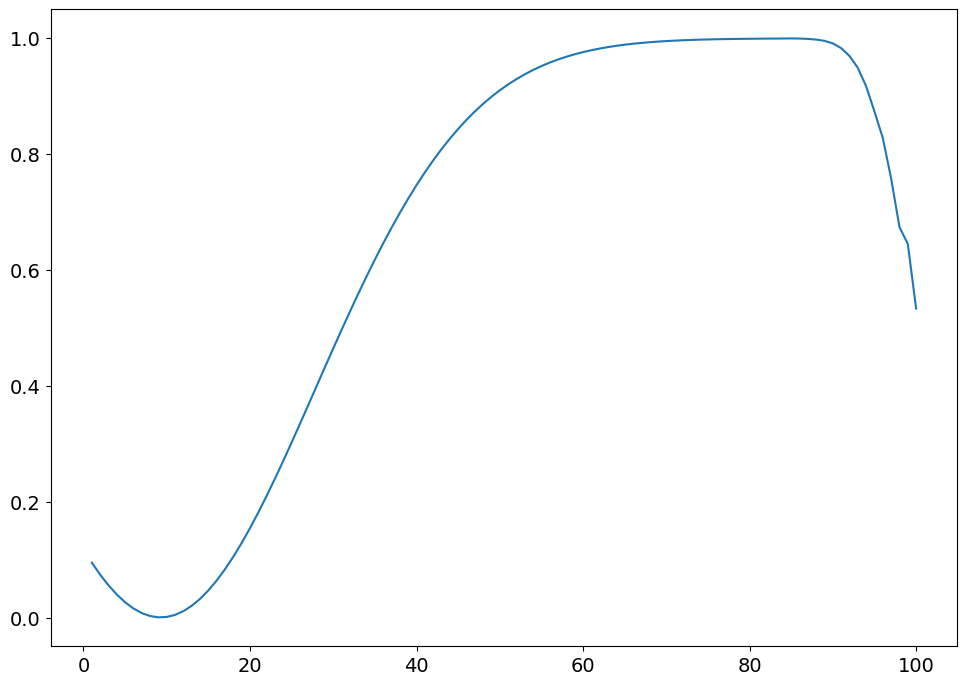

In [2]:
t_displace = np.linspace(0,0.12,10)
t_wait = np.linspace(0,0.8,10)
epsilon = 64

def overlapWithIdeal(epsilon):
    ideal  = CD_ideal_operator(1j)*vac
    exp = Rx(np.pi)*ECD_exp(vac, t_displace, t_wait, 1, epsilon = epsilon)
    overlap = exp.overlap(ideal)
    
    return 1-abs(overlap)

eps = np.linspace(1,100,100)

overlaps = []
for i in eps:
    overlaps.append(overlapWithIdeal(i))
plt.plot(eps,overlaps)
print(eps[np.argmin(overlaps)])
epsilon = eps[np.argmin(overlaps)]


### loading epxerimental data

In [3]:
from scipy.optimize import curve_fit
import numpy as np 
import matplotlib.pyplot as plt
import h5py
from numpy import ma

def gauss_1(x, amp1, cen1, sigma1, offset):
    return amp1 * (np.exp((-1.0 / 2.0) * (((x - cen1) / sigma1) ** 2))) + offset

def load_1d(fname, d, thresh, plot =False):

    ps = []
    if 1:# this is for 7dB cat
        fp1 = [d + f for f in os.listdir(d) if f.endswith(fname +'.h5')]
        files1 = fp1[:]
    #     d2 = "C:/Users/qcrew/Desktop/qcrew/data/squeezing/20221110/"
    #     fp2 = [d2 + f for f in os.listdir(d2) if f.endswith(fname +'.h5')]
    #     fps = np.concatenate([fp1, fp2[:-1]])
    #     decay_times = np.array([1e3, 10e3, 20e3, 35e3, 50e3, 70e3, 100e3, 150e3, 200e3])
        
    dg = []
    de = []
    dts = []

    vac_contrast =1 ## update with real experimental values
    for kk in range(len(files1)):
        fname = files1[kk]
        df = h5py.File(fname, "r")
        data = df["data"]
        data_i = data["I"][:]
        data_q = data['Q'][:]
        dt = df.attrs['decay_time']
        x = data["x"][:, 0]
        #y = data["y"][0, :, 0]

        thresh = thresh
        raw_m0 = data_i[:, 0::3]
        raw_m1 = data_i[:, 1::3] 
        raw_m2 = data_i[:, 2::3]

        m0 = np.where(raw_m0 < thresh, 1, 0)
        m1 = np.where(raw_m1 < thresh, 1, 0)
        m2 = np.where(raw_m2 < thresh, 1, 0)
        
        m1_g = ma.masked_array(m1, mask=m0)
        m2_g = ma.masked_array(m2, mask=m0)

        double_ps_g = ma.masked_array(m2_g, mask=m1).mean(axis=0)*2-1
        double_ps_e = ma.masked_array(m2_g, mask=np.logical_not(m1)).mean(axis=0)*2-1

        dg.append(double_ps_g/vac_contrast)
        de.append(double_ps_e/vac_contrast)
        dts.append(dt)
        

    dg = np.array(dg)
    de = np.array(de)
    dts = np.array(dts)
    decay_times = np.unique(dts)
    dd = {}
    for n in range(len(decay_times)):
            dd[str(decay_times[n])] = []

    for n, dt in enumerate(dts):
        dd[str(dt)].append(dg[n])
        
    d_avg = {}
    for n, dt in enumerate(dts): 
        d_avg[str(dt)] = np.array(dd[str(dt)]).mean(axis=0)


    import math

    rows = len(decay_times)
    cols = 1
    if plot:
        fig, axes = plt.subplots(rows, cols, figsize=(16, 12))
        # for i in range(rows):
        for j in range(rows):
            axes.plot(x, d_avg[str(decay_times[j])][:])
            axes.set_aspect("equal")
            axes.set_title(str(dts[j]))
        #         l += 1      
        plt.show()
    return  d_avg, x
    



[ 4.66888552e+02 -1.03809747e-01]
0.0002223437397790017


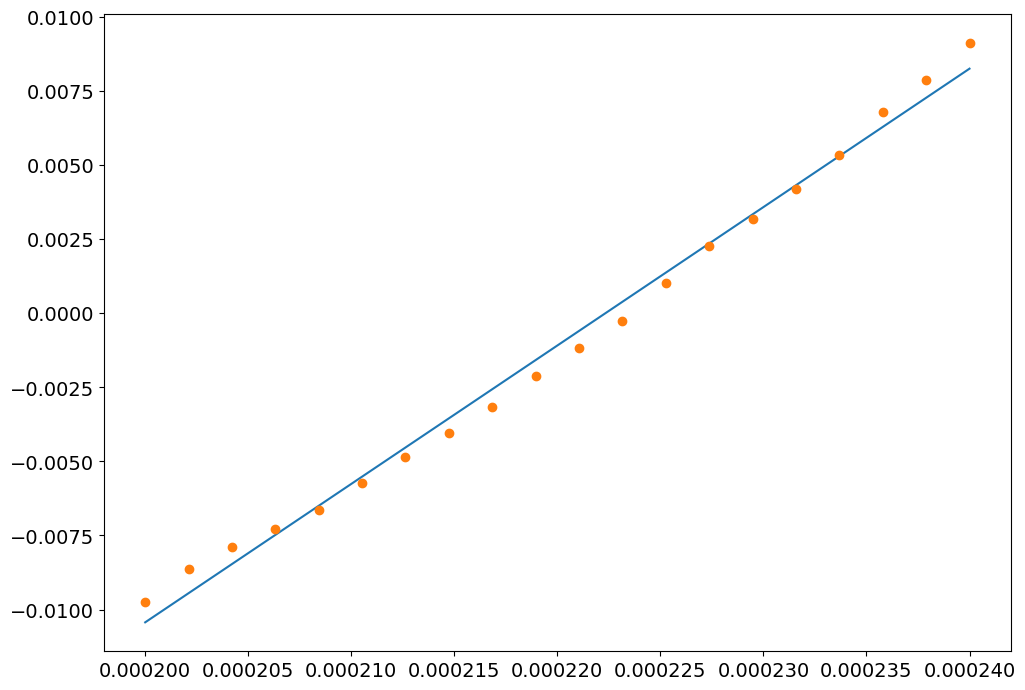

In [4]:
from scipy.optimize import curve_fit
fnames = ['panther_sq_vcat_3db_vac_1dx', 'panther_sq_vcat_6db_vac_1dy']#, 'panther_sq_vcat_7db_vac_1dy',  ]


d =  "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/squeezing/"

thresholds = np.linspace(2e-4,2.4e-4, 20)
floor_values = []
for threshold in thresholds:
    data_array, x = load_1d(fnames[0], d, threshold)
    floor_values.append(np.concatenate((data_array["16"][:100],  + data_array["16"][-100:])).mean())


def line(x, m, y):
    return x*m+y
popt, pcov = curve_fit(line, thresholds, floor_values, p0= [0,0])
print(popt)
plt.plot(thresholds,line(np.array(thresholds),*popt))
plt.plot(thresholds,floor_values, 'o')
thresh = (-popt[1]/popt[0])
print(thresh)

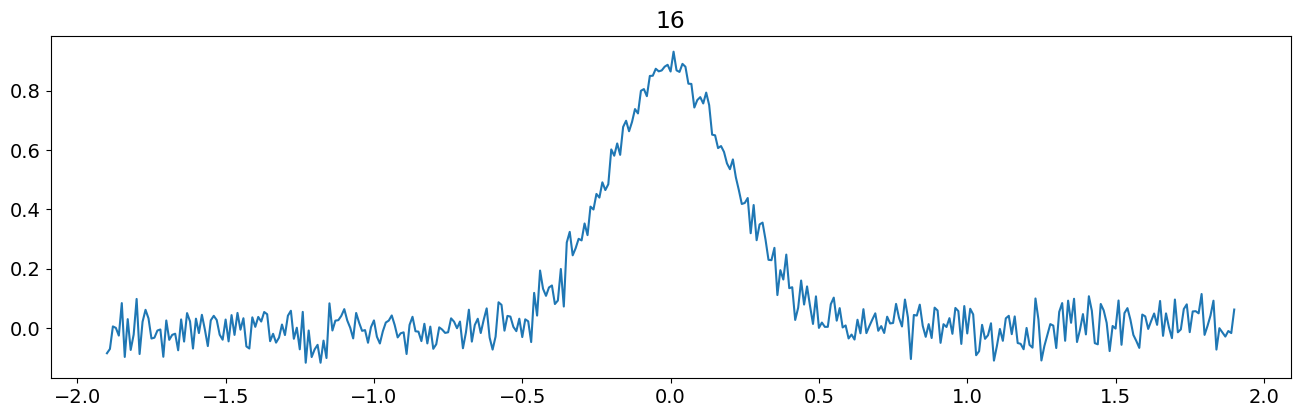

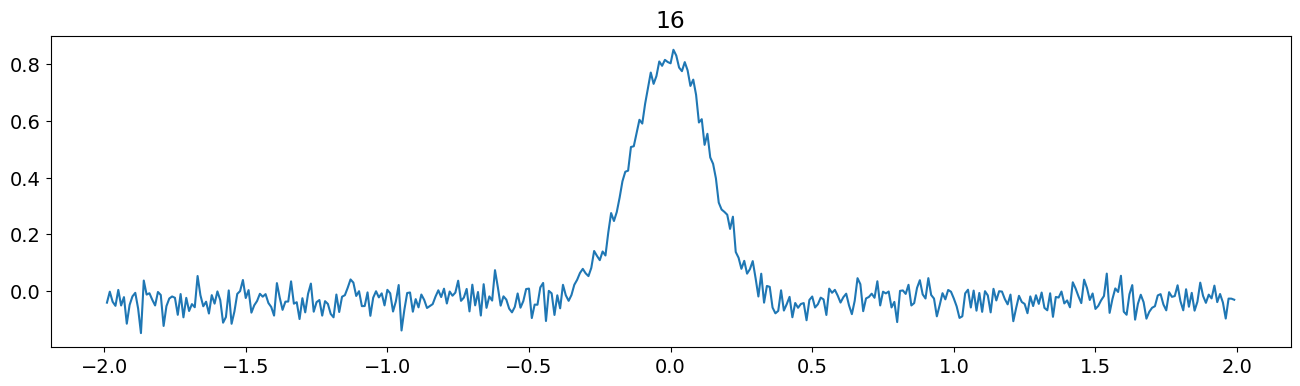

In [5]:
cut_data = []
x_data_3 = []
for fname in fnames:
    data_array, x = load_1d(fname, d, thresh, plot= True)
    cut_data.append(data_array["16"])
    x_data_3.append(x*3)

### calculate theoretical cuts

In [6]:

uv3 = [ 1.38744578,  0.51199234, -0.19874056, -0.46461027, -0.3244084,  -0.65943663]
uv6 = [ 1.62946677,  0.39181981, -0.48019506, -1.04030892, -1.10939512,
        0.32484321]
uvs = [uv3, uv6]
xvec_3 = x_data_3[0]
t2s = [np.inf, 20]

squeezed3 = []
squeezed6 = []
for t2 in t2s:
    squeezed3.append(ptrace((proj_g*squeezing_loss_3uv(uvs[0], np.inf, t2)).unit(),1).unit())
    squeezed6.append(ptrace((proj_g*squeezing_loss_3uv(uvs[1], np.inf, t2)).unit(),1).unit())
    


cut_3 = []
cut_6 = []

for i in range(len(t2s)):
    cut_3.append(char_func_cut(squeezed3[i],xvec_3, axis = 1j))
    cut_6.append(char_func_cut(squeezed6[i],xvec_3, axis = 1j))


## Plotting

In [51]:
import matplotlib as mpl


cm = 1.0/2.54  # centimeters in inches

mpl.rcParams['lines.linewidth'] = 0.5
mpl.rcParams['boxplot.flierprops.markersize'] = 1
mpl.rcParams['figure.figsize'] = [8*cm, 4*cm]
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['xtick.major.size'] = 1.5
mpl.rcParams['ytick.major.size'] = 1.5
mpl.rcParams['xtick.minor.size'] = 1.5
mpl.rcParams['ytick.minor.size'] = 1.5
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['xtick.major.top'] = False
mpl.rcParams['xtick.major.bottom'] = True
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['xtick.labelbottom'] = False
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.labelleft'] = False
mpl.rcParams['ytick.direction'] = 'in'


colours = [([0.07, 0.49, 0.44]),
 ([0.95, 0.65, 0.23]),
 ([0.95, 0.29, 0.14]),
 ([0.45, 0.13, 0.34]),
 ([0.13, 0.13, 0.26])]

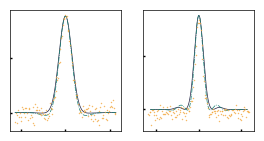

In [12]:
%matplotlib inline
fig, axs = plt.subplots(1, len(uvs))

cuts = [cut_3, cut_6]
marker_style = dict(marker='o', 
                    linestyle = 'none', 
                    markersize= 0.7, 
                    markeredgewidth = 0.3, 
                    markerfacecolor='none',
                          )

data_scale = np.max(cut_data[0][::5])
axs[0].plot(xvec_3, np.array(cut_3[0])*data_scale, color = colours[4])
axs[0].plot(xvec_3, np.array(cut_3[1])*data_scale, "-.", color = colours[0])
axs[0].plot(x_data_3[0][::3], cut_data[0][::3] , **marker_style , color = colours[1])
axs[1].plot(xvec_3, np.array(cut_6[0])*data_scale, color = colours[4])
axs[1].plot(xvec_3, np.array(cut_6[1])*data_scale, "-.", color = colours[0])
axs[1].plot(x_data_3[1][::3], cut_data[1][::3] , **marker_style , color = colours[1])

    
plt.savefig("suppl_squeezing.pdf")


# Cat state

### Theoretical Data

In [13]:
def create_cat(rho, alpha, t1,t2):
    q_decay = np.sqrt(1 / t1) * (sx + 1j * sy) / 2
    q_dephasing = np.sqrt(1 / t2) * sz
    loss = [q_decay,q_dephasing]
    psi1 = U(rho, t_displace, t_wait, 2*alpha*1j, epsilon = epsilon, loss=loss)
    psi2 = (proj_e*psi1).unit()
    return psi2


In [14]:

alphas =[1.2743, 0.902]

cat_state_3 = []
for i, t2 in enumerate(t2s):
    cat_state = create_cat(tensor(fock(2,0)*fock(2,0).dag(),squeezed3[i]),alphas[0],np.inf,t2)
    cat_state_3.append(cat_state)
    
cat_state_6 = []
for i, t2 in enumerate(t2s):
    cat_state = create_cat(tensor(fock(2,0)*fock(2,0).dag(),squeezed6[i]),alphas[1],np.inf,t2)
    cat_state_6.append(cat_state)

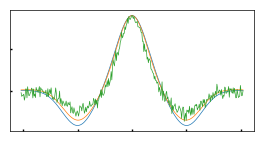

In [20]:
xvec_cat = x_cat*3
cut3_0 = char_func_cut(ptrace(cat_state_3[0],1).unit(), xvec_cat, 1j)
cut3_20 = char_func_cut(ptrace(cat_state_3[1],1).unit(), xvec_cat, 1j)
plt.plot(xvec_cat,np.array(cut3_0)*np.max(data3))
plt.plot(xvec_cat,np.array(cut3_20)*np.max(data3))
plt.plot(xvec_cat, data3)

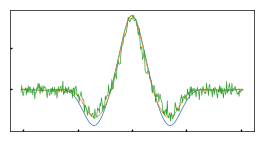

In [21]:
cut6_0 = char_func_cut(ptrace(cat_state_6[0],1).unit(),xvec_cat, 1j)
cut6_20 = char_func_cut(ptrace(cat_state_6[1],1).unit(),xvec_cat, 1j)
plt.plot(xvec_cat,np.array(cut6_0)*np.max(data6))
plt.plot(xvec_cat,np.array(cut6_20)*np.max(data6))
plt.plot(xvec_cat, data6)

In [15]:
## experimental data
x_cat = np.array([-1.70000000e+00, -1.69000000e+00, -1.68000000e+00, -1.66999999e+00,
       -1.65999999e+00, -1.64999999e+00, -1.63999999e+00, -1.62999999e+00,
       -1.61999999e+00, -1.60999998e+00, -1.59999998e+00, -1.58999998e+00,
       -1.57999998e+00, -1.56999998e+00, -1.55999998e+00, -1.54999997e+00,
       -1.53999997e+00, -1.52999997e+00, -1.51999997e+00, -1.50999997e+00,
       -1.49999997e+00, -1.48999996e+00, -1.47999996e+00, -1.46999996e+00,
       -1.45999996e+00, -1.44999996e+00, -1.43999996e+00, -1.42999995e+00,
       -1.41999995e+00, -1.40999995e+00, -1.39999995e+00, -1.38999995e+00,
       -1.37999995e+00, -1.36999995e+00, -1.35999994e+00, -1.34999994e+00,
       -1.33999994e+00, -1.32999994e+00, -1.31999994e+00, -1.30999994e+00,
       -1.29999993e+00, -1.28999993e+00, -1.27999993e+00, -1.26999993e+00,
       -1.25999993e+00, -1.24999993e+00, -1.23999992e+00, -1.22999992e+00,
       -1.21999992e+00, -1.20999992e+00, -1.19999992e+00, -1.18999992e+00,
       -1.17999991e+00, -1.16999991e+00, -1.15999991e+00, -1.14999991e+00,
       -1.13999991e+00, -1.12999991e+00, -1.11999990e+00, -1.10999990e+00,
       -1.09999990e+00, -1.08999990e+00, -1.07999990e+00, -1.06999990e+00,
       -1.05999989e+00, -1.04999989e+00, -1.03999989e+00, -1.02999989e+00,
       -1.01999989e+00, -1.00999989e+00, -9.99999885e-01, -9.89999883e-01,
       -9.79999881e-01, -9.69999880e-01, -9.59999878e-01, -9.49999876e-01,
       -9.39999875e-01, -9.29999873e-01, -9.19999871e-01, -9.09999870e-01,
       -8.99999868e-01, -8.89999866e-01, -8.79999865e-01, -8.69999863e-01,
       -8.59999862e-01, -8.49999860e-01, -8.39999858e-01, -8.29999857e-01,
       -8.19999855e-01, -8.09999853e-01, -7.99999852e-01, -7.89999850e-01,
       -7.79999848e-01, -7.69999847e-01, -7.59999845e-01, -7.49999844e-01,
       -7.39999842e-01, -7.29999840e-01, -7.19999839e-01, -7.09999837e-01,
       -6.99999835e-01, -6.89999834e-01, -6.79999832e-01, -6.69999830e-01,
       -6.59999829e-01, -6.49999827e-01, -6.39999826e-01, -6.29999824e-01,
       -6.19999822e-01, -6.09999821e-01, -5.99999819e-01, -5.89999817e-01,
       -5.79999816e-01, -5.69999814e-01, -5.59999812e-01, -5.49999811e-01,
       -5.39999809e-01, -5.29999807e-01, -5.19999806e-01, -5.09999804e-01,
       -4.99999803e-01, -4.89999801e-01, -4.79999799e-01, -4.69999798e-01,
       -4.59999796e-01, -4.49999794e-01, -4.39999793e-01, -4.29999791e-01,
       -4.19999789e-01, -4.09999788e-01, -3.99999786e-01, -3.89999785e-01,
       -3.79999783e-01, -3.69999781e-01, -3.59999780e-01, -3.49999778e-01,
       -3.39999776e-01, -3.29999775e-01, -3.19999773e-01, -3.09999771e-01,
       -2.99999770e-01, -2.89999768e-01, -2.79999766e-01, -2.69999765e-01,
       -2.59999763e-01, -2.49999762e-01, -2.39999760e-01, -2.29999758e-01,
       -2.19999757e-01, -2.09999755e-01, -1.99999753e-01, -1.89999752e-01,
       -1.79999750e-01, -1.69999748e-01, -1.59999747e-01, -1.49999745e-01,
       -1.39999744e-01, -1.29999742e-01, -1.19999740e-01, -1.09999739e-01,
       -9.99997370e-02, -8.99997354e-02, -7.99997337e-02, -6.99997321e-02,
       -5.99997304e-02, -4.99997288e-02, -3.99997272e-02, -2.99997255e-02,
       -1.99997239e-02, -9.99972224e-03,  2.79396772e-07,  1.00002810e-02,
        2.00002827e-02,  3.00002843e-02,  4.00002860e-02,  5.00002876e-02,
        6.00002892e-02,  7.00002909e-02,  8.00002925e-02,  9.00002941e-02,
        1.00000296e-01,  1.10000297e-01,  1.20000299e-01,  1.30000301e-01,
        1.40000302e-01,  1.50000304e-01,  1.60000306e-01,  1.70000307e-01,
        1.80000309e-01,  1.90000311e-01,  2.00000312e-01,  2.10000314e-01,
        2.20000315e-01,  2.30000317e-01,  2.40000319e-01,  2.50000320e-01,
        2.60000322e-01,  2.70000324e-01,  2.80000325e-01,  2.90000327e-01,
        3.00000329e-01,  3.10000330e-01,  3.20000332e-01,  3.30000333e-01,
        3.40000335e-01,  3.50000337e-01,  3.60000338e-01,  3.70000340e-01,
        3.80000342e-01,  3.90000343e-01,  4.00000345e-01,  4.10000347e-01,
        4.20000348e-01,  4.30000350e-01,  4.40000352e-01,  4.50000353e-01,
        4.60000355e-01,  4.70000356e-01,  4.80000358e-01,  4.90000360e-01,
        5.00000361e-01,  5.10000363e-01,  5.20000365e-01,  5.30000366e-01,
        5.40000368e-01,  5.50000370e-01,  5.60000371e-01,  5.70000373e-01,
        5.80000374e-01,  5.90000376e-01,  6.00000378e-01,  6.10000379e-01,
        6.20000381e-01,  6.30000383e-01,  6.40000384e-01,  6.50000386e-01,
        6.60000388e-01,  6.70000389e-01,  6.80000391e-01,  6.90000392e-01,
        7.00000394e-01,  7.10000396e-01,  7.20000397e-01,  7.30000399e-01,
        7.40000401e-01,  7.50000402e-01,  7.60000404e-01,  7.70000406e-01,
        7.80000407e-01,  7.90000409e-01,  8.00000411e-01,  8.10000412e-01,
        8.20000414e-01,  8.30000415e-01,  8.40000417e-01,  8.50000419e-01,
        8.60000420e-01,  8.70000422e-01,  8.80000424e-01,  8.90000425e-01,
        9.00000427e-01,  9.10000429e-01,  9.20000430e-01,  9.30000432e-01,
        9.40000433e-01,  9.50000435e-01,  9.60000437e-01,  9.70000438e-01,
        9.80000440e-01,  9.90000442e-01,  1.00000044e+00,  1.01000044e+00,
        1.02000045e+00,  1.03000045e+00,  1.04000045e+00,  1.05000045e+00,
        1.06000045e+00,  1.07000045e+00,  1.08000046e+00,  1.09000046e+00,
        1.10000046e+00,  1.11000046e+00,  1.12000046e+00,  1.13000046e+00,
        1.14000047e+00,  1.15000047e+00,  1.16000047e+00,  1.17000047e+00,
        1.18000047e+00,  1.19000047e+00,  1.20000048e+00,  1.21000048e+00,
        1.22000048e+00,  1.23000048e+00,  1.24000048e+00,  1.25000048e+00,
        1.26000049e+00,  1.27000049e+00,  1.28000049e+00,  1.29000049e+00,
        1.30000049e+00,  1.31000049e+00,  1.32000050e+00,  1.33000050e+00,
        1.34000050e+00,  1.35000050e+00,  1.36000050e+00,  1.37000050e+00,
        1.38000051e+00,  1.39000051e+00,  1.40000051e+00,  1.41000051e+00,
        1.42000051e+00,  1.43000051e+00,  1.44000052e+00,  1.45000052e+00,
        1.46000052e+00,  1.47000052e+00,  1.48000052e+00,  1.49000052e+00,
        1.50000053e+00,  1.51000053e+00,  1.52000053e+00,  1.53000053e+00,
        1.54000053e+00,  1.55000053e+00,  1.56000054e+00,  1.57000054e+00,
        1.58000054e+00,  1.59000054e+00,  1.60000054e+00,  1.61000054e+00,
        1.62000054e+00,  1.63000055e+00,  1.64000055e+00,  1.65000055e+00,
        1.66000055e+00,  1.67000055e+00,  1.68000055e+00,  1.69000056e+00,
        1.70000056e+00])

data3 = np.array([-0.02441845, -0.06874065, -0.05657554, -0.05491651, -0.04293045,
       -0.11360215, -0.0780959 ,  0.02048094,  0.01961587, -0.08615899,
        0.0465873 , -0.01599908, -0.06081723, -0.05449463, -0.02846053,
       -0.01950206,  0.03023564,  0.01735173, -0.08734765,  0.0198221 ,
       -0.06452028, -0.04353419, -0.08334676,  0.03888991,  0.00705689,
        0.00774114, -0.02335747,  0.01019536,  0.04890768, -0.07415007,
        0.03545433,  0.01708899,  0.00667099,  0.00896141, -0.02534524,
       -0.01923612, -0.02389173, -0.03281419,  0.00551908, -0.0705883 ,
       -0.06958785,  0.02273059, -0.07197552, -0.02104147,  0.01471439,
       -0.03683315,  0.03359624, -0.04429378, -0.09752565, -0.08192148,
       -0.10686514, -0.09942945, -0.04072857,  0.03253496, -0.03032241,
       -0.14089189, -0.11028067, -0.09246846, -0.08910597, -0.00496051,
       -0.15465341, -0.09334921, -0.13273853, -0.17981183, -0.12244506,
       -0.13810425, -0.15779588, -0.18213233, -0.16151259, -0.12407241,
       -0.17833319, -0.18705488, -0.14085568, -0.16194547, -0.16876971,
       -0.13372021, -0.26548782, -0.21831284, -0.19139399, -0.25898593,
       -0.27158275, -0.20421906, -0.24497073, -0.26632217, -0.30389136,
       -0.26793759, -0.24152688, -0.2651625 , -0.30313511, -0.25955695,
       -0.18029246, -0.19662394, -0.19451469, -0.24098515, -0.1760558 ,
       -0.15032614, -0.21168105, -0.26919472, -0.2418229 , -0.19594974,
       -0.25207382, -0.20778365, -0.18287632, -0.20666798, -0.18343259,
       -0.12605327, -0.17640632, -0.18731539, -0.17836935, -0.16088088,
       -0.16362364, -0.09128566, -0.11541832, -0.16961118, -0.09901899,
       -0.15966751, -0.11406995, -0.20733161, -0.12062876, -0.10883488,
       -0.05436817, -0.06641478,  0.00907182, -0.08260998,  0.0103579 ,
       -0.0488686 , -0.05647151, -0.03879304, -0.01433747,  0.06902516,
        0.04315295,  0.06317971,  0.11956091,  0.04567734,  0.14397191,
        0.06061707,  0.10003835,  0.13333952,  0.22648542,  0.12766584,
        0.28405641,  0.36788375,  0.32169252,  0.29304569,  0.37159579,
        0.47789503,  0.3577782 ,  0.44631569,  0.45226118,  0.421525  ,
        0.48869021,  0.50971652,  0.57742472,  0.60165558,  0.69751034,
        0.62706848,  0.64226406,  0.68300534,  0.67979702,  0.76026474,
        0.72553678,  0.77546741,  0.79822943,  0.8602261 ,  0.79960911,
        0.88233383,  0.85684292,  0.84400751,  0.85951324,  0.87764417,
        0.89628882,  0.87629864,  0.85606269,  0.88297542,  0.84151952,
        0.81366063,  0.80644999,  0.81274538,  0.82518135,  0.75872002,
        0.75769894,  0.75416765,  0.75026397,  0.7239884 ,  0.69090648,
        0.69008535,  0.58540633,  0.58876659,  0.46386985,  0.55564498,
        0.47331067,  0.4674791 ,  0.4875824 ,  0.37390845,  0.3973331 ,
        0.33122206,  0.38046114,  0.36868769,  0.3509712 ,  0.25804104,
        0.25344121,  0.2279875 ,  0.21044732,  0.20034396,  0.13641572,
        0.17282784,  0.12035422,  0.12085824,  0.08797669,  0.10186717,
        0.07805082, -0.01585651,  0.03915309,  0.00286522, -0.06130939,
       -0.01625414,  0.10453638, -0.1148498 , -0.00472216, -0.05690271,
       -0.12928895, -0.11857383, -0.03125592, -0.00808136, -0.09689478,
       -0.07528817, -0.14441603, -0.11872752, -0.18556447, -0.15432037,
       -0.08665968, -0.27342123, -0.17448219, -0.23368401, -0.1839292 ,
       -0.18074634, -0.1554993 , -0.22097087, -0.221661  , -0.25901825,
       -0.24625729, -0.22651966, -0.18119351, -0.20181935, -0.21963344,
       -0.24877451, -0.3319605 , -0.22669832, -0.19494644, -0.20053941,
       -0.36528188, -0.30570154, -0.26870465, -0.353017  , -0.23097193,
       -0.24895254, -0.23233747, -0.2711355 , -0.18563751, -0.25503417,
       -0.29473032, -0.2056001 , -0.28290686, -0.20753909, -0.23124486,
       -0.2821776 , -0.18362816, -0.16722342, -0.18213081, -0.1620042 ,
       -0.22956281, -0.20701238, -0.19582914, -0.15946467, -0.23570556,
       -0.12590745, -0.12559081, -0.15828926, -0.19006841, -0.10407961,
       -0.14526256, -0.1061312 , -0.20098588, -0.18078626, -0.10584418,
       -0.11509828, -0.10179608, -0.09849849, -0.03813067, -0.07842112,
       -0.13324694, -0.05421559, -0.07005581, -0.10758422, -0.02242962,
       -0.05712737, -0.08501688, -0.03799594, -0.00784973, -0.06327767,
        0.07728733,  0.02908608, -0.02982063, -0.01170139,  0.0073701 ,
       -0.00144174, -0.05407213,  0.01353683, -0.05533687, -0.09500517,
       -0.05628199, -0.06587483,  0.04260148,  0.03275769, -0.03270071,
       -0.02756758, -0.01091423,  0.00286266,  0.04900179, -0.07863263,
        0.0264604 ,  0.00885348,  0.02187417, -0.02396579, -0.03037769,
        0.03317056, -0.03291101,  0.02796978, -0.03724762, -0.08594221,
       -0.08414818,  0.01632102, -0.03869142, -0.08183925, -0.07354882,
       -0.0637984 ,  0.06207747, -0.00760614, -0.06170703, -0.05560032,
       -0.00204978])


data6 = np.array([-3.23778365e-02,  4.91865724e-02, -2.22886560e-02, -7.88781913e-02,
       -3.85101881e-02,  1.97429907e-03, -3.47463992e-03,  2.09808763e-02,
       -6.64311316e-02,  1.33704167e-02, -3.68539201e-02,  4.38888602e-02,
       -4.32880568e-02,  2.86212903e-02,  2.69351115e-02, -3.86335580e-02,
       -3.48927195e-02, -9.44539238e-03, -6.54918437e-02,  2.39172835e-02,
       -4.07170961e-04, -1.14807700e-01, -3.53387681e-02, -4.20241818e-02,
        2.27540254e-02,  4.87514483e-03,  7.72144073e-02,  1.14179736e-02,
        6.86232564e-02, -5.61364646e-02,  3.29700411e-02, -2.53055350e-02,
        4.65034505e-02, -3.44213148e-02,  6.19720043e-03,  4.33376114e-02,
        1.49865727e-02,  1.96390742e-02,  2.03620718e-02, -4.36909429e-02,
       -1.01382704e-01, -1.05281144e-02,  1.13574211e-04, -5.43328273e-02,
       -7.20315030e-02, -2.14028223e-02,  1.60650507e-02, -5.63788449e-02,
        2.73225017e-02, -2.81421597e-02, -8.55073450e-03,  2.49822960e-02,
       -7.06729576e-02, -1.17273699e-02,  3.07198421e-03, -1.05468641e-01,
       -2.60590794e-02,  3.23291343e-02, -3.40077655e-02, -1.35413113e-02,
        3.15613650e-02,  3.90680400e-02, -3.29444941e-02, -1.34883693e-03,
        1.00883409e-01, -6.21448167e-02, -1.96365258e-02, -4.39210687e-02,
        3.00535552e-02, -3.84885980e-02,  1.76523389e-02, -4.65096079e-02,
        5.59399435e-03,  2.97765661e-02, -3.05340803e-02, -4.50204279e-02,
       -1.84031458e-03, -3.58211925e-02,  7.73592756e-03, -1.03862890e-01,
        1.26194819e-02,  2.09578661e-02, -7.08643730e-02,  2.42435277e-02,
        3.89822340e-02, -1.30057761e-02, -8.12228004e-02, -7.42032980e-02,
       -5.55803506e-02, -1.53833729e-01, -8.49004291e-02, -6.43781141e-02,
       -2.59537783e-02, -8.80494474e-02, -1.16852079e-01, -1.25098899e-01,
       -1.22343338e-01, -2.72382467e-01, -1.87156937e-01, -2.01152414e-01,
       -2.23067209e-01, -2.65145973e-01, -3.10802752e-01, -2.37442768e-01,
       -2.00410567e-01, -2.77798505e-01, -3.03392360e-01, -3.11126758e-01,
       -3.23025514e-01, -2.85738016e-01, -2.85866119e-01, -3.41576747e-01,
       -3.53285156e-01, -2.34434700e-01, -3.00346833e-01, -3.28073750e-01,
       -3.20256451e-01, -2.21387411e-01, -2.42372484e-01, -2.34165649e-01,
       -2.80189752e-01, -1.65918767e-01, -1.95199506e-01, -9.87157994e-02,
       -1.38272808e-01, -2.65414469e-01, -1.92469340e-01, -2.17785886e-01,
       -2.23994974e-01, -7.81222219e-02, -1.21297701e-01, -9.09930832e-02,
       -6.78987291e-02, -7.20754599e-02,  5.67014291e-02, -3.88039946e-02,
       -5.65605653e-02,  2.89822418e-03, -1.84478474e-02,  1.19799952e-01,
        3.56120592e-03,  1.01045382e-02,  7.62366921e-02,  1.68549102e-01,
        1.86532341e-01,  1.52530567e-01,  1.23223884e-01,  2.63372443e-01,
        2.86566146e-01,  3.36995484e-01,  3.04213998e-01,  3.04207125e-01,
        3.10149879e-01,  4.36350001e-01,  4.99854102e-01,  5.28865686e-01,
        5.44091263e-01,  6.01917037e-01,  6.48254191e-01,  6.37092845e-01,
        6.68491628e-01,  6.83222147e-01,  7.23147014e-01,  7.74994108e-01,
        8.68602422e-01,  8.42241344e-01,  8.18572637e-01,  8.13803720e-01,
        8.47305104e-01,  8.54501500e-01,  8.41244705e-01,  8.84816656e-01,
        8.90835255e-01,  8.33072700e-01,  8.23238799e-01,  8.39341421e-01,
        8.40910633e-01,  7.62737948e-01,  7.68917609e-01,  6.82621116e-01,
        6.52744521e-01,  7.37003982e-01,  6.04329173e-01,  4.82176352e-01,
        5.06946243e-01,  5.03015801e-01,  3.57295808e-01,  3.82014529e-01,
        4.35035918e-01,  4.61511985e-01,  2.24665741e-01,  2.02099046e-01,
        1.99259396e-01,  1.87482590e-01,  2.20644794e-01,  2.25935790e-01,
        2.21321003e-01,  1.43769412e-01,  1.20034918e-01,  1.12323140e-01,
        2.10665473e-02, -4.56573279e-02,  1.69409800e-02,  3.92985017e-02,
        4.43506772e-02, -1.02628157e-02, -1.54391568e-01, -5.12705031e-02,
       -8.66588743e-02, -8.33175443e-02, -4.20184755e-02, -1.50780879e-01,
       -8.35418962e-02, -5.59910722e-02, -1.12848692e-01, -1.41142573e-01,
       -1.62567485e-01, -2.50530596e-01, -2.92927157e-01, -2.49647864e-01,
       -3.11442148e-01, -2.65187481e-01, -2.37505856e-01, -3.07676959e-01,
       -1.35701800e-01, -3.22131146e-01, -3.41331352e-01, -2.99987442e-01,
       -2.82494331e-01, -3.81578904e-01, -2.78196357e-01, -3.01989063e-01,
       -3.52717545e-01, -3.37844466e-01, -3.07213666e-01, -3.12918989e-01,
       -1.54310288e-01, -1.93112731e-01, -2.49745113e-01, -2.19535520e-01,
       -2.55803678e-01, -2.32643985e-01, -2.65377911e-01, -2.13629555e-01,
       -1.27053907e-01, -9.48593704e-02, -6.62130257e-02, -1.61305031e-01,
       -9.54042393e-02, -8.42548541e-02, -1.04958541e-01, -6.06456294e-02,
       -8.84196775e-02, -1.32610596e-01, -7.53430393e-02,  5.06330848e-03,
       -6.01761093e-02, -3.56766696e-02, -1.11441821e-01,  3.44996409e-02,
       -4.68061476e-02,  2.93400642e-02, -7.02279494e-02,  8.70072077e-03,
       -1.05439737e-02,  1.44855503e-02, -3.38745602e-02, -4.26462703e-03,
       -9.07600459e-02, -3.75625568e-02,  2.59507148e-02, -1.11836401e-02,
       -2.11403759e-02, -1.24261785e-01,  2.44107238e-03,  9.64678728e-03,
       -8.25454695e-03, -7.09140549e-02,  1.40808453e-02,  3.28368756e-02,
       -1.91585576e-02, -4.45709135e-02, -3.41875751e-02, -5.07392995e-02,
        7.70128222e-02,  1.01027933e-02,  9.47261433e-03, -7.45623259e-02,
        3.97305339e-02,  6.22575986e-02, -1.86143958e-02, -1.65037470e-02,
       -1.29801920e-02, -9.10966881e-02, -9.78897573e-03,  1.70807843e-02,
       -6.25631852e-02,  2.74736910e-02,  9.84365187e-03,  1.41594360e-03,
       -6.23388492e-02, -1.03747480e-01, -1.31759977e-03, -3.14872116e-02,
        4.62745286e-02, -4.65034176e-02,  3.47583417e-02, -5.36134620e-02,
        1.62812506e-02, -4.39804615e-02, -1.04862792e-01,  1.42988263e-02,
       -2.25866354e-03, -6.34864354e-02, -3.28398573e-02,  9.81350483e-02,
       -4.64814812e-02, -1.87576569e-03, -2.18560177e-02,  7.69786587e-02,
        2.57406363e-02, -4.75521011e-02, -6.38101450e-02,  7.43483727e-02,
       -2.54220892e-02, -1.00484205e-02,  1.43412825e-02,  1.17921945e-02,
        3.81663946e-02, -1.49004131e-02, -1.95099442e-03, -5.62247077e-02,
       -5.28964770e-02, -2.42841675e-02, -8.31753697e-02,  4.79985490e-03,
       -3.27774182e-02, -2.63674269e-02,  6.05876511e-04, -9.80242242e-03,
       -9.01420076e-03])

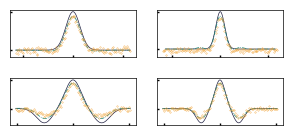

In [54]:
%matplotlib inline
fig, axs = plt.subplots(2, 2)

cuts = [cut_3, cut_6]
marker_style = dict(marker='o', 
                    linestyle = 'none', 
                    markersize= 1, 
                    markeredgewidth = 0.3, 
                    markerfacecolor='none',
                          )

data_scale = np.max(cut_data[0][::5])
axs[0,0].plot(xvec_3, sq_ideal[0], color = colours[4])
axs[0,0].plot(xvec_3, np.array(cut_3[1])*data_scale, "-.", color = colours[0])
axs[0,0].plot(x_data_3[0][::3], cut_data[0][::3] , **marker_style , color = colours[1])
#axs[0,0].set_title("3 dB",fontsize=8)
#axs[0,0].set_ylabel("vac",fontsize=8)

axs[0,1].plot(xvec_3, sq_ideal[1], color = colours[4])
axs[0,1].plot(xvec_3, np.array(cut_6[1])*data_scale, "-.", color = colours[0])
axs[0,1].plot(x_data_3[1][::3], cut_data[1][::3] , **marker_style , color = colours[1])
#axs[0,1].set_title("6 dB",fontsize=8)



axs[1,0].plot(xvec_cat,cat_ideal[0], color = colours[4])
axs[1,0].plot(xvec_cat,np.array(cut3_20)*np.max(data3), "-.", color = colours[0])
axs[1,0].plot(xvec_cat[::3], data3[::3],**marker_style , color = colours[1])
#axs[1,0].set_ylabel("cat",fontsize=8)
#axs[1,0].set_xlabel(r'$Re[\alpha]$', fontsize=8)


axs[1,1].plot(xvec_cat,cat_ideal[1], color = colours[4])
axs[1,1].plot(xvec_cat,np.array(cut6_20)*np.max(data6), "-.", color = colours[0])
axs[1,1].plot(xvec_cat[::3], data6[::3],**marker_style , color = colours[1])
#axs[1,1].set_xlabel(r'$Re[\alpha]$', fontsize=8)


plt.tight_layout()
plt.savefig("suppl_squeezing.pdf")

In [59]:
np.savez("cuts", cut3_20 = cut3_20, cut6_20 = cut6_20 )

In [31]:
def calc_squeez_parameter(dB):
    return np.log(10**(dB/10))/2

### States
alpha = 1.8
cat = (coherent(N,alpha) - coherent(N,-alpha)).unit()

dBs = [3,6.7]

# first cat, then squeeze
sq_states = [squeeze(N,calc_squeez_parameter(i))*fock(N,0) for i in dBs]
cat_states = [squeeze(N,calc_squeez_parameter(i))for i in dBs]*cat

In [32]:
char_func_cut(squeezed3[i],xvec_3)
sq_ideal = []
cat_ideal = []
for i in range(len(sq_states)):
    sq_cut = char_func_cut(sq_states[i],xvec_3 )
    cat_cut = char_func_cut(cat_states[i],xvec_cat)
    sq_ideal.append(sq_cut)
    cat_ideal.append(cat_cut)

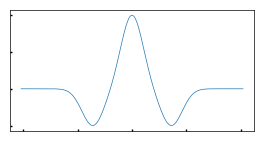

In [35]:
plt.plot(xvec_cat,cat_ideal[1])

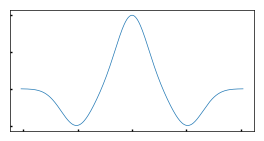

In [34]:
plt.plot(xvec_cat,cat_ideal[0])

In [58]:
x_data_3

[array([-5.70000000e+00, -5.66999999e+00, -5.63999999e+00, -5.60999998e+00,
        -5.57999998e+00, -5.54999997e+00, -5.51999997e+00, -5.48999996e+00,
        -5.45999996e+00, -5.42999995e+00, -5.39999995e+00, -5.36999994e+00,
        -5.33999994e+00, -5.30999993e+00, -5.27999993e+00, -5.24999992e+00,
        -5.21999992e+00, -5.18999991e+00, -5.15999991e+00, -5.12999990e+00,
        -5.09999990e+00, -5.06999989e+00, -5.03999989e+00, -5.00999988e+00,
        -4.97999988e+00, -4.94999987e+00, -4.91999987e+00, -4.88999986e+00,
        -4.85999986e+00, -4.82999985e+00, -4.79999985e+00, -4.76999984e+00,
        -4.73999984e+00, -4.70999983e+00, -4.67999983e+00, -4.64999982e+00,
        -4.61999982e+00, -4.58999981e+00, -4.55999981e+00, -4.52999980e+00,
        -4.49999980e+00, -4.46999979e+00, -4.43999979e+00, -4.40999978e+00,
        -4.37999978e+00, -4.34999977e+00, -4.31999977e+00, -4.28999976e+00,
        -4.25999976e+00, -4.22999975e+00, -4.19999975e+00, -4.16999974e+00,
        -4.1